In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

c:\Users\jaesc2\GitHub\skforecast


In [2]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import date_to_index_position

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)
Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


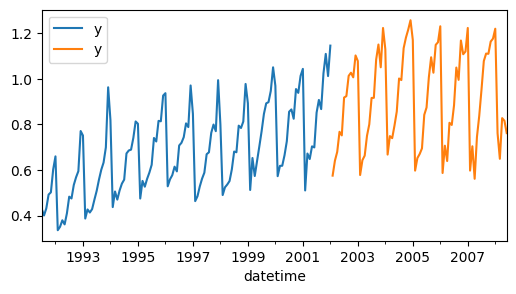

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543


In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_train:])})"
)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

display(data.head(4))

In [6]:
date_to_index_position(data.index, '2002-01-01 00:00:00', method='validation')

126

In [7]:
data.index[126]

Timestamp('2002-01-01 00:00:00')

In [9]:
data.iloc[:126].tail(2)

,y
datetime,
2001-11-01,1.109590
2001-12-01,1.012313


In [11]:
len(data.iloc[:126])

126

In [10]:
data.iloc[:126 + 1].tail(2)

,y
datetime,
2001-12-01,1.012313
2002-01-01,1.145868


In [19]:
# Create TimeSeriesFold
# ==============================================================================
cv = TimeSeriesFold(
         steps                 = 10,
         initial_train_size    = len(data.loc[:end_train]),
         window_size           = 10,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

cv.split(X=data, as_pandas=True)

,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,127,117,127,127,137,127,137,True
1,1,0,137,127,137,137,147,137,147,True
2,2,0,147,137,147,147,157,147,157,True
3,3,0,157,147,157,157,167,157,167,True
4,4,0,167,157,167,167,177,167,177,True
5,5,0,177,167,177,177,187,177,187,True
6,6,0,187,177,187,187,197,187,197,True
7,7,0,197,187,197,197,204,197,204,True


In [14]:
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 15,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[10])
             )
forecaster.fit(y=data.loc[:end_train]['y'])

In [16]:
forecaster.last_window_.tail()

,y
datetime,
2001-09-01,0.867444
2001-10-01,1.024293
2001-11-01,1.109590
2001-12-01,1.012313
2002-01-01,1.145868


In [17]:
forecaster.predict(steps='2002-02-01')

2002-02-01    0.570082
Freq: MS, Name: pred, dtype: float64

In [18]:
pd.date_range(start=forecaster.last_window_.index[-1], end=pd.to_datetime('2002-02-01'), freq=forecaster.last_window_.index.freq)

DatetimeIndex(['2002-01-01', '2002-02-01'], dtype='datetime64[ns]', freq='MS')

In [25]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 15,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[10])
             )

cv = TimeSeriesFold(
         steps                 = 10,
        #  initial_train_size    = len(data.loc[:end_train]),
         initial_train_size    = '2002-01-01 00:00:00',
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['y'],
                          cv            = cv,
                          metric        = 'mean_squared_error',
                          n_jobs        = 'auto',
                          verbose       = False,
                          show_progress = True
                      )

predictions.head(2)

TypeError: cannot do positional indexing on DatetimeIndex with these indexers [2002-01-01 00:00:00] of type str

In [24]:
None + 5

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'